# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # Aufruf LR scheduler für reduce on plateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.1569
Epoch 1/200, Iteration 2/25, Loss: 2.2723
Epoch 1/200, Iteration 3/25, Loss: 2.8011
Epoch 1/200, Iteration 4/25, Loss: 1.9028
Epoch 1/200, Iteration 5/25, Loss: 0.4196
Epoch 1/200, Iteration 6/25, Loss: 0.8034
Epoch 1/200, Iteration 7/25, Loss: 1.0149
Epoch 1/200, Iteration 8/25, Loss: 0.6287
Epoch 1/200, Iteration 9/25, Loss: 0.1107
Epoch 1/200, Iteration 10/25, Loss: 0.4233
Epoch 1/200, Iteration 11/25, Loss: 0.5261
Epoch 1/200, Iteration 12/25, Loss: 0.4422
Epoch 1/200, Iteration 13/25, Loss: 0.3235
Epoch 1/200, Iteration 14/25, Loss: 0.2002
Epoch 1/200, Iteration 15/25, Loss: 0.2692
Epoch 1/200, Iteration 16/25, Loss: 0.1959
Epoch 1/200, Iteration 17/25, Loss: 0.1220
Epoch 1/200, Iteration 18/25, Loss: 0.1357
Epoch 1/200, Iteration 19/25, Loss: 0.1600
Epoch 1/200, Iteration 20/25, Loss: 0.0790
Epoch 1/200, Iteration 21/25, Loss: 0.2293
Epoch 1/200, Iteration 22/25, Loss: 0.1139
Epoch 1/200, Iteration 23/25, Loss: 0.2727
Epoch 1/200, Iterati

Train Error: 
 Accuracy: 28.5%, Avg loss: 0.068882, MRE: 6.301617 

Test Error: 
 Accuracy: 35.0%, Avg loss: 0.060882, MRE: 5.690228 

Epoch 8/200, Iteration 1/25, Loss: 0.0861
Epoch 8/200, Iteration 2/25, Loss: 0.0699
Epoch 8/200, Iteration 3/25, Loss: 0.0513
Epoch 8/200, Iteration 4/25, Loss: 0.0434
Epoch 8/200, Iteration 5/25, Loss: 0.0764
Epoch 8/200, Iteration 6/25, Loss: 0.0527
Epoch 8/200, Iteration 7/25, Loss: 0.0721
Epoch 8/200, Iteration 8/25, Loss: 0.0596
Epoch 8/200, Iteration 9/25, Loss: 0.0848
Epoch 8/200, Iteration 10/25, Loss: 0.0842
Epoch 8/200, Iteration 11/25, Loss: 0.0944
Epoch 8/200, Iteration 12/25, Loss: 0.0959
Epoch 8/200, Iteration 13/25, Loss: 0.0541
Epoch 8/200, Iteration 14/25, Loss: 0.1169
Epoch 8/200, Iteration 15/25, Loss: 0.0702
Epoch 8/200, Iteration 16/25, Loss: 0.0973
Epoch 8/200, Iteration 17/25, Loss: 0.1181
Epoch 8/200, Iteration 18/25, Loss: 0.0857
Epoch 8/200, Iteration 19/25, Loss: 0.1026
Epoch 8/200, Iteration 20/25, Loss: 0.1132
Epoch 8/200, I

Train Error: 
 Accuracy: 33.88%, Avg loss: 0.034598, MRE: 2.526318 

Test Error: 
 Accuracy: 37.0%, Avg loss: 0.036419, MRE: 2.765199 

Epoch 15/200, Iteration 1/25, Loss: 0.0347
Epoch 15/200, Iteration 2/25, Loss: 0.0371
Epoch 15/200, Iteration 3/25, Loss: 0.0380
Epoch 15/200, Iteration 4/25, Loss: 0.0330
Epoch 15/200, Iteration 5/25, Loss: 0.0634
Epoch 15/200, Iteration 6/25, Loss: 0.0353
Epoch 15/200, Iteration 7/25, Loss: 0.0453
Epoch 15/200, Iteration 8/25, Loss: 0.0234
Epoch 15/200, Iteration 9/25, Loss: 0.0655
Epoch 15/200, Iteration 10/25, Loss: 0.0330
Epoch 15/200, Iteration 11/25, Loss: 0.0242
Epoch 15/200, Iteration 12/25, Loss: 0.0297
Epoch 15/200, Iteration 13/25, Loss: 0.0548
Epoch 15/200, Iteration 14/25, Loss: 0.0435
Epoch 15/200, Iteration 15/25, Loss: 0.0527
Epoch 15/200, Iteration 16/25, Loss: 0.0637
Epoch 15/200, Iteration 17/25, Loss: 0.0589
Epoch 15/200, Iteration 18/25, Loss: 0.0443
Epoch 15/200, Iteration 19/25, Loss: 0.0266
Epoch 15/200, Iteration 20/25, Loss: 

Epoch 22/200, Iteration 5/25, Loss: 0.0488
Epoch 22/200, Iteration 6/25, Loss: 0.0296
Epoch 22/200, Iteration 7/25, Loss: 0.0366
Epoch 22/200, Iteration 8/25, Loss: 0.0424
Epoch 22/200, Iteration 9/25, Loss: 0.0482
Epoch 22/200, Iteration 10/25, Loss: 0.0443
Epoch 22/200, Iteration 11/25, Loss: 0.0596
Epoch 22/200, Iteration 12/25, Loss: 0.0425
Epoch 22/200, Iteration 13/25, Loss: 0.0393
Epoch 22/200, Iteration 14/25, Loss: 0.0583
Epoch 22/200, Iteration 15/25, Loss: 0.0471
Epoch 22/200, Iteration 16/25, Loss: 0.0495
Epoch 22/200, Iteration 17/25, Loss: 0.0497
Epoch 22/200, Iteration 18/25, Loss: 0.0461
Epoch 22/200, Iteration 19/25, Loss: 0.0464
Epoch 22/200, Iteration 20/25, Loss: 0.0437
Epoch 22/200, Iteration 21/25, Loss: 0.0295
Epoch 22/200, Iteration 22/25, Loss: 0.0669
Epoch 22/200, Iteration 23/25, Loss: 0.0546
Epoch 22/200, Iteration 24/25, Loss: 0.0902
Epoch 22/200, Iteration 25/25, Loss: 0.1128
Train Error: 
 Accuracy: 59.25%, Avg loss: 0.056816, MRE: 2.704086 

Test Error: 

Epoch 29/200, Iteration 17/25, Loss: 0.0154
Epoch 29/200, Iteration 18/25, Loss: 0.0119
Epoch 29/200, Iteration 19/25, Loss: 0.0134
Epoch 29/200, Iteration 20/25, Loss: 0.0121
Epoch 29/200, Iteration 21/25, Loss: 0.0195
Epoch 29/200, Iteration 22/25, Loss: 0.0156
Epoch 29/200, Iteration 23/25, Loss: 0.0108
Epoch 29/200, Iteration 24/25, Loss: 0.0203
Epoch 29/200, Iteration 25/25, Loss: 0.0207
Train Error: 
 Accuracy: 82.5%, Avg loss: 0.014345, MRE: 0.835723 

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.016977, MRE: 3.029781 

Epoch 30/200, Iteration 1/25, Loss: 0.0150
Epoch 30/200, Iteration 2/25, Loss: 0.0183
Epoch 30/200, Iteration 3/25, Loss: 0.0230
Epoch 30/200, Iteration 4/25, Loss: 0.0130
Epoch 30/200, Iteration 5/25, Loss: 0.0282
Epoch 30/200, Iteration 6/25, Loss: 0.0158
Epoch 30/200, Iteration 7/25, Loss: 0.0371
Epoch 30/200, Iteration 8/25, Loss: 0.0155
Epoch 30/200, Iteration 9/25, Loss: 0.0110
Epoch 30/200, Iteration 10/25, Loss: 0.0148
Epoch 30/200, Iteration 11/25, Loss: 0

Epoch 36/200, Iteration 25/25, Loss: 0.0221
Train Error: 
 Accuracy: 82.25%, Avg loss: 0.012525, MRE: 0.834517 

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.013228, MRE: 1.246474 

Epoch 37/200, Iteration 1/25, Loss: 0.0169
Epoch 37/200, Iteration 2/25, Loss: 0.0160
Epoch 37/200, Iteration 3/25, Loss: 0.0394
Epoch 37/200, Iteration 4/25, Loss: 0.0110
Epoch 37/200, Iteration 5/25, Loss: 0.0213
Epoch 37/200, Iteration 6/25, Loss: 0.0278
Epoch 37/200, Iteration 7/25, Loss: 0.0350
Epoch 37/200, Iteration 8/25, Loss: 0.0178
Epoch 37/200, Iteration 9/25, Loss: 0.0132
Epoch 37/200, Iteration 10/25, Loss: 0.0175
Epoch 37/200, Iteration 11/25, Loss: 0.0327
Epoch 37/200, Iteration 12/25, Loss: 0.0165
Epoch 37/200, Iteration 13/25, Loss: 0.0163
Epoch 37/200, Iteration 14/25, Loss: 0.0339
Epoch 37/200, Iteration 15/25, Loss: 0.0144
Epoch 37/200, Iteration 16/25, Loss: 0.0169
Epoch 37/200, Iteration 17/25, Loss: 0.0134
Epoch 37/200, Iteration 18/25, Loss: 0.0199
Epoch 37/200, Iteration 19/25, Loss: 

Epoch 44/200, Iteration 5/25, Loss: 0.0188
Epoch 44/200, Iteration 6/25, Loss: 0.0159
Epoch 44/200, Iteration 7/25, Loss: 0.0213
Epoch 44/200, Iteration 8/25, Loss: 0.0171
Epoch 44/200, Iteration 9/25, Loss: 0.0158
Epoch 44/200, Iteration 10/25, Loss: 0.0261
Epoch 44/200, Iteration 11/25, Loss: 0.0133
Epoch 44/200, Iteration 12/25, Loss: 0.0195
Epoch 44/200, Iteration 13/25, Loss: 0.0291
Epoch 44/200, Iteration 14/25, Loss: 0.0176
Epoch 44/200, Iteration 15/25, Loss: 0.0388
Epoch 44/200, Iteration 16/25, Loss: 0.0127
Epoch 44/200, Iteration 17/25, Loss: 0.0188
Epoch 44/200, Iteration 18/25, Loss: 0.0153
Epoch 44/200, Iteration 19/25, Loss: 0.0278
Epoch 44/200, Iteration 20/25, Loss: 0.0203
Epoch 44/200, Iteration 21/25, Loss: 0.0138
Epoch 44/200, Iteration 22/25, Loss: 0.0169
Epoch 44/200, Iteration 23/25, Loss: 0.0393
Epoch 44/200, Iteration 24/25, Loss: 0.0153
Epoch 44/200, Iteration 25/25, Loss: 0.0226
Train Error: 
 Accuracy: 82.75%, Avg loss: 0.014288, MRE: 1.206374 

Test Error: 

Train Error: 
 Accuracy: 54.12%, Avg loss: 0.012595, MRE: 0.907189 

Test Error: 
 Accuracy: 58.5%, Avg loss: 0.013152, MRE: 1.380113 

Epoch 51/200, Iteration 1/25, Loss: 0.0118
Epoch 51/200, Iteration 2/25, Loss: 0.0163
Epoch 51/200, Iteration 3/25, Loss: 0.0421
Epoch 51/200, Iteration 4/25, Loss: 0.0182
Epoch 51/200, Iteration 5/25, Loss: 0.0162
Epoch 51/200, Iteration 6/25, Loss: 0.0181
Epoch 51/200, Iteration 7/25, Loss: 0.0135
Epoch 51/200, Iteration 8/25, Loss: 0.0146
Epoch 51/200, Iteration 9/25, Loss: 0.0140
Epoch 51/200, Iteration 10/25, Loss: 0.0235
Epoch 51/200, Iteration 11/25, Loss: 0.0188
Epoch 51/200, Iteration 12/25, Loss: 0.0267
Epoch 51/200, Iteration 13/25, Loss: 0.0222
Epoch 51/200, Iteration 14/25, Loss: 0.0164
Epoch 51/200, Iteration 15/25, Loss: 0.0271
Epoch 51/200, Iteration 16/25, Loss: 0.0079
Epoch 51/200, Iteration 17/25, Loss: 0.0126
Epoch 51/200, Iteration 18/25, Loss: 0.0248
Epoch 51/200, Iteration 19/25, Loss: 0.0117
Epoch 51/200, Iteration 20/25, Loss: 

Epoch 58/200, Iteration 21/25, Loss: 0.0137
Epoch 58/200, Iteration 22/25, Loss: 0.0120
Epoch 58/200, Iteration 23/25, Loss: 0.0085
Epoch 58/200, Iteration 24/25, Loss: 0.0254
Epoch 58/200, Iteration 25/25, Loss: 0.0066
Train Error: 
 Accuracy: 92.5%, Avg loss: 0.006462, MRE: 0.400200 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.008174, MRE: 0.879161 

Epoch 59/200, Iteration 1/25, Loss: 0.0159
Epoch 59/200, Iteration 2/25, Loss: 0.0076
Epoch 59/200, Iteration 3/25, Loss: 0.0141
Epoch 59/200, Iteration 4/25, Loss: 0.0101
Epoch 59/200, Iteration 5/25, Loss: 0.0218
Epoch 59/200, Iteration 6/25, Loss: 0.0146
Epoch 59/200, Iteration 7/25, Loss: 0.0193
Epoch 59/200, Iteration 8/25, Loss: 0.0146
Epoch 59/200, Iteration 9/25, Loss: 0.0079
Epoch 59/200, Iteration 10/25, Loss: 0.0092
Epoch 59/200, Iteration 11/25, Loss: 0.0155
Epoch 59/200, Iteration 12/25, Loss: 0.0137
Epoch 59/200, Iteration 13/25, Loss: 0.0253
Epoch 59/200, Iteration 14/25, Loss: 0.0086
Epoch 59/200, Iteration 15/25, Loss: 0

Epoch 66/200, Iteration 10/25, Loss: 0.0189
Epoch 66/200, Iteration 11/25, Loss: 0.0069
Epoch 66/200, Iteration 12/25, Loss: 0.0078
Epoch 66/200, Iteration 13/25, Loss: 0.0162
Epoch 66/200, Iteration 14/25, Loss: 0.0058
Epoch 66/200, Iteration 15/25, Loss: 0.0118
Epoch 66/200, Iteration 16/25, Loss: 0.0104
Epoch 66/200, Iteration 17/25, Loss: 0.0223
Epoch 66/200, Iteration 18/25, Loss: 0.0138
Epoch 66/200, Iteration 19/25, Loss: 0.0100
Epoch 66/200, Iteration 20/25, Loss: 0.0099
Epoch 66/200, Iteration 21/25, Loss: 0.0248
Epoch 66/200, Iteration 22/25, Loss: 0.0109
Epoch 66/200, Iteration 23/25, Loss: 0.0234
Epoch 66/200, Iteration 24/25, Loss: 0.0065
Epoch 66/200, Iteration 25/25, Loss: 0.0208
Train Error: 
 Accuracy: 95.62%, Avg loss: 0.005878, MRE: 0.366743 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.006803, MRE: 1.206129 

Epoch 67/200, Iteration 1/25, Loss: 0.0242
Epoch 67/200, Iteration 2/25, Loss: 0.0073
Epoch 67/200, Iteration 3/25, Loss: 0.0155
Epoch 67/200, Iteration 4/25, L

Train Error: 
 Accuracy: 89.75%, Avg loss: 0.005340, MRE: 0.344843 

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.006212, MRE: 1.027588 

Epoch 74/200, Iteration 1/25, Loss: 0.0198
Epoch 74/200, Iteration 2/25, Loss: 0.0138
Epoch 74/200, Iteration 3/25, Loss: 0.0145
Epoch 74/200, Iteration 4/25, Loss: 0.0134
Epoch 74/200, Iteration 5/25, Loss: 0.0439
Epoch 74/200, Iteration 6/25, Loss: 0.0148
Epoch 74/200, Iteration 7/25, Loss: 0.0077
Epoch 74/200, Iteration 8/25, Loss: 0.0108
Epoch 74/200, Iteration 9/25, Loss: 0.0065
Epoch 74/200, Iteration 10/25, Loss: 0.0186
Epoch 74/200, Iteration 11/25, Loss: 0.0330
Epoch 74/200, Iteration 12/25, Loss: 0.0273
Epoch 74/200, Iteration 13/25, Loss: 0.0161
Epoch 74/200, Iteration 14/25, Loss: 0.0102
Epoch 74/200, Iteration 15/25, Loss: 0.0108
Epoch 74/200, Iteration 16/25, Loss: 0.0192
Epoch 74/200, Iteration 17/25, Loss: 0.0231
Epoch 74/200, Iteration 18/25, Loss: 0.0212
Epoch 74/200, Iteration 19/25, Loss: 0.0177
Epoch 74/200, Iteration 20/25, Loss: 

Epoch 81/200, Iteration 12/25, Loss: 0.0109
Epoch 81/200, Iteration 13/25, Loss: 0.0240
Epoch 81/200, Iteration 14/25, Loss: 0.0301
Epoch 81/200, Iteration 15/25, Loss: 0.0335
Epoch 81/200, Iteration 16/25, Loss: 0.0081
Epoch 81/200, Iteration 17/25, Loss: 0.0080
Epoch 81/200, Iteration 18/25, Loss: 0.0188
Epoch 81/200, Iteration 19/25, Loss: 0.0112
Epoch 81/200, Iteration 20/25, Loss: 0.0106
Epoch 81/200, Iteration 21/25, Loss: 0.0324
Epoch 81/200, Iteration 22/25, Loss: 0.0138
Epoch 81/200, Iteration 23/25, Loss: 0.0091
Epoch 81/200, Iteration 24/25, Loss: 0.0176
Epoch 81/200, Iteration 25/25, Loss: 0.0075
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.006003, MRE: 0.325543 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.007284, MRE: 1.481921 

Epoch 82/200, Iteration 1/25, Loss: 0.0086
Epoch 82/200, Iteration 2/25, Loss: 0.0151
Epoch 82/200, Iteration 3/25, Loss: 0.0062
Epoch 82/200, Iteration 4/25, Loss: 0.0109
Epoch 82/200, Iteration 5/25, Loss: 0.0123
Epoch 82/200, Iteration 6/25, Los

Epoch 89/200, Iteration 11/25, Loss: 0.0117
Epoch 89/200, Iteration 12/25, Loss: 0.0062
Epoch 89/200, Iteration 13/25, Loss: 0.0256
Epoch 89/200, Iteration 14/25, Loss: 0.0146
Epoch 89/200, Iteration 15/25, Loss: 0.0266
Epoch 89/200, Iteration 16/25, Loss: 0.0116
Epoch 89/200, Iteration 17/25, Loss: 0.0269
Epoch 89/200, Iteration 18/25, Loss: 0.0116
Epoch 89/200, Iteration 19/25, Loss: 0.0083
Epoch 89/200, Iteration 20/25, Loss: 0.0137
Epoch 89/200, Iteration 21/25, Loss: 0.0091
Epoch 89/200, Iteration 22/25, Loss: 0.0065
Epoch 89/200, Iteration 23/25, Loss: 0.0096
Epoch 89/200, Iteration 24/25, Loss: 0.0358
Epoch 89/200, Iteration 25/25, Loss: 0.0215
Train Error: 
 Accuracy: 93.12%, Avg loss: 0.005192, MRE: 0.302564 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.005814, MRE: 1.422475 

Epoch 90/200, Iteration 1/25, Loss: 0.0070
Epoch 90/200, Iteration 2/25, Loss: 0.0235
Epoch 90/200, Iteration 3/25, Loss: 0.0156
Epoch 90/200, Iteration 4/25, Loss: 0.0175
Epoch 90/200, Iteration 5/25, Lo

Epoch 96/200, Iteration 25/25, Loss: 0.0195
Train Error: 
 Accuracy: 95.75%, Avg loss: 0.004898, MRE: 0.313202 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.005921, MRE: 1.281251 

Epoch 97/200, Iteration 1/25, Loss: 0.0041
Epoch 97/200, Iteration 2/25, Loss: 0.0173
Epoch 97/200, Iteration 3/25, Loss: 0.0055
Epoch 97/200, Iteration 4/25, Loss: 0.0100
Epoch 97/200, Iteration 5/25, Loss: 0.0171
Epoch 97/200, Iteration 6/25, Loss: 0.0248
Epoch 97/200, Iteration 7/25, Loss: 0.0138
Epoch 97/200, Iteration 8/25, Loss: 0.0079
Epoch 97/200, Iteration 9/25, Loss: 0.0071
Epoch 97/200, Iteration 10/25, Loss: 0.0074
Epoch 97/200, Iteration 11/25, Loss: 0.0047
Epoch 97/200, Iteration 12/25, Loss: 0.0223
Epoch 97/200, Iteration 13/25, Loss: 0.0073
Epoch 97/200, Iteration 14/25, Loss: 0.0156
Epoch 97/200, Iteration 15/25, Loss: 0.0079
Epoch 97/200, Iteration 16/25, Loss: 0.0123
Epoch 97/200, Iteration 17/25, Loss: 0.0250
Epoch 97/200, Iteration 18/25, Loss: 0.0155
Epoch 97/200, Iteration 19/25, Loss: 

Train Error: 
 Accuracy: 95.38%, Avg loss: 0.004848, MRE: 0.336649 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.006306, MRE: 1.058839 

Epoch 104/200, Iteration 1/25, Loss: 0.0057
Epoch 104/200, Iteration 2/25, Loss: 0.0351
Epoch 104/200, Iteration 3/25, Loss: 0.0124
Epoch 104/200, Iteration 4/25, Loss: 0.0104
Epoch 104/200, Iteration 5/25, Loss: 0.0145
Epoch 104/200, Iteration 6/25, Loss: 0.0099
Epoch 104/200, Iteration 7/25, Loss: 0.0114
Epoch 104/200, Iteration 8/25, Loss: 0.0238
Epoch 104/200, Iteration 9/25, Loss: 0.0162
Epoch 104/200, Iteration 10/25, Loss: 0.0070
Epoch 104/200, Iteration 11/25, Loss: 0.0091
Epoch 104/200, Iteration 12/25, Loss: 0.0181
Epoch 104/200, Iteration 13/25, Loss: 0.0234
Epoch 104/200, Iteration 14/25, Loss: 0.0062
Epoch 104/200, Iteration 15/25, Loss: 0.0166
Epoch 104/200, Iteration 16/25, Loss: 0.0076
Epoch 104/200, Iteration 17/25, Loss: 0.0113
Epoch 104/200, Iteration 18/25, Loss: 0.0095
Epoch 104/200, Iteration 19/25, Loss: 0.0071
Epoch 104/200, Ite

Train Error: 
 Accuracy: 92.5%, Avg loss: 0.005038, MRE: 0.344877 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.006023, MRE: 1.073082 

Epoch 111/200, Iteration 1/25, Loss: 0.0169
Epoch 111/200, Iteration 2/25, Loss: 0.0101
Epoch 111/200, Iteration 3/25, Loss: 0.0092
Epoch 111/200, Iteration 4/25, Loss: 0.0070
Epoch 111/200, Iteration 5/25, Loss: 0.0088
Epoch 111/200, Iteration 6/25, Loss: 0.0094
Epoch 111/200, Iteration 7/25, Loss: 0.0094
Epoch 111/200, Iteration 8/25, Loss: 0.0223
Epoch 111/200, Iteration 9/25, Loss: 0.0287
Epoch 111/200, Iteration 10/25, Loss: 0.0170
Epoch 111/200, Iteration 11/25, Loss: 0.0163
Epoch 111/200, Iteration 12/25, Loss: 0.0099
Epoch 111/200, Iteration 13/25, Loss: 0.0077
Epoch 111/200, Iteration 14/25, Loss: 0.0143
Epoch 111/200, Iteration 15/25, Loss: 0.0067
Epoch 111/200, Iteration 16/25, Loss: 0.0117
Epoch 111/200, Iteration 17/25, Loss: 0.0314
Epoch 111/200, Iteration 18/25, Loss: 0.0109
Epoch 111/200, Iteration 19/25, Loss: 0.0078
Epoch 111/200, Iter

Epoch 118/200, Iteration 14/25, Loss: 0.0091
Epoch 118/200, Iteration 15/25, Loss: 0.0101
Epoch 118/200, Iteration 16/25, Loss: 0.0069
Epoch 118/200, Iteration 17/25, Loss: 0.0088
Epoch 118/200, Iteration 18/25, Loss: 0.0092
Epoch 118/200, Iteration 19/25, Loss: 0.0124
Epoch 118/200, Iteration 20/25, Loss: 0.0125
Epoch 118/200, Iteration 21/25, Loss: 0.0218
Epoch 118/200, Iteration 22/25, Loss: 0.0074
Epoch 118/200, Iteration 23/25, Loss: 0.0055
Epoch 118/200, Iteration 24/25, Loss: 0.0142
Epoch 118/200, Iteration 25/25, Loss: 0.0130
Train Error: 
 Accuracy: 95.12%, Avg loss: 0.004698, MRE: 0.300539 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.005634, MRE: 1.236020 

Epoch 119/200, Iteration 1/25, Loss: 0.0217
Epoch 119/200, Iteration 2/25, Loss: 0.0145
Epoch 119/200, Iteration 3/25, Loss: 0.0128
Epoch 119/200, Iteration 4/25, Loss: 0.0322
Epoch 119/200, Iteration 5/25, Loss: 0.0247
Epoch 119/200, Iteration 6/25, Loss: 0.0126
Epoch 119/200, Iteration 7/25, Loss: 0.0098
Epoch 119/200, I

Train Error: 
 Accuracy: 93.62%, Avg loss: 0.004713, MRE: 0.308405 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.005645, MRE: 1.129877 

Epoch 126/200, Iteration 1/25, Loss: 0.0069
Epoch 126/200, Iteration 2/25, Loss: 0.0109
Epoch 126/200, Iteration 3/25, Loss: 0.0064
Epoch 126/200, Iteration 4/25, Loss: 0.0091
Epoch 126/200, Iteration 5/25, Loss: 0.0152
Epoch 126/200, Iteration 6/25, Loss: 0.0102
Epoch 126/200, Iteration 7/25, Loss: 0.0127
Epoch 126/200, Iteration 8/25, Loss: 0.0148
Epoch 126/200, Iteration 9/25, Loss: 0.0125
Epoch 126/200, Iteration 10/25, Loss: 0.0122
Epoch 126/200, Iteration 11/25, Loss: 0.0094
Epoch 126/200, Iteration 12/25, Loss: 0.0157
Epoch 126/200, Iteration 13/25, Loss: 0.0133
Epoch 126/200, Iteration 14/25, Loss: 0.0067
Epoch 126/200, Iteration 15/25, Loss: 0.0097
Epoch 126/200, Iteration 16/25, Loss: 0.0066
Epoch 126/200, Iteration 17/25, Loss: 0.0131
Epoch 126/200, Iteration 18/25, Loss: 0.0068
Epoch 126/200, Iteration 19/25, Loss: 0.0182
Epoch 126/200, Ite

Train Error: 
 Accuracy: 93.62%, Avg loss: 0.004708, MRE: 0.321074 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.005630, MRE: 1.059496 

Epoch 133/200, Iteration 1/25, Loss: 0.0176
Epoch 133/200, Iteration 2/25, Loss: 0.0117
Epoch 133/200, Iteration 3/25, Loss: 0.0114
Epoch 133/200, Iteration 4/25, Loss: 0.0069
Epoch 133/200, Iteration 5/25, Loss: 0.0107
Epoch 133/200, Iteration 6/25, Loss: 0.0136
Epoch 133/200, Iteration 7/25, Loss: 0.0196
Epoch 133/200, Iteration 8/25, Loss: 0.0162
Epoch 133/200, Iteration 9/25, Loss: 0.0172
Epoch 133/200, Iteration 10/25, Loss: 0.0072
Epoch 133/200, Iteration 11/25, Loss: 0.0151
Epoch 133/200, Iteration 12/25, Loss: 0.0098
Epoch 133/200, Iteration 13/25, Loss: 0.0067
Epoch 133/200, Iteration 14/25, Loss: 0.0105
Epoch 133/200, Iteration 15/25, Loss: 0.0085
Epoch 133/200, Iteration 16/25, Loss: 0.0072
Epoch 133/200, Iteration 17/25, Loss: 0.0079
Epoch 133/200, Iteration 18/25, Loss: 0.0160
Epoch 133/200, Iteration 19/25, Loss: 0.0200
Epoch 133/200, Ite

Epoch 140/200, Iteration 4/25, Loss: 0.0139
Epoch 140/200, Iteration 5/25, Loss: 0.0078
Epoch 140/200, Iteration 6/25, Loss: 0.0157
Epoch 140/200, Iteration 7/25, Loss: 0.0237
Epoch 140/200, Iteration 8/25, Loss: 0.0093
Epoch 140/200, Iteration 9/25, Loss: 0.0097
Epoch 140/200, Iteration 10/25, Loss: 0.0156
Epoch 140/200, Iteration 11/25, Loss: 0.0112
Epoch 140/200, Iteration 12/25, Loss: 0.0235
Epoch 140/200, Iteration 13/25, Loss: 0.0069
Epoch 140/200, Iteration 14/25, Loss: 0.0099
Epoch 140/200, Iteration 15/25, Loss: 0.0106
Epoch 140/200, Iteration 16/25, Loss: 0.0081
Epoch 140/200, Iteration 17/25, Loss: 0.0328
Epoch 140/200, Iteration 18/25, Loss: 0.0218
Epoch 140/200, Iteration 19/25, Loss: 0.0102
Epoch 140/200, Iteration 20/25, Loss: 0.0082
Epoch 140/200, Iteration 21/25, Loss: 0.0064
Epoch 140/200, Iteration 22/25, Loss: 0.0062
Epoch 140/200, Iteration 23/25, Loss: 0.0165
Epoch 140/200, Iteration 24/25, Loss: 0.0063
Epoch 140/200, Iteration 25/25, Loss: 0.0171
Train Error: 
 A

Epoch 147/200, Iteration 16/25, Loss: 0.0068
Epoch 147/200, Iteration 17/25, Loss: 0.0107
Epoch 147/200, Iteration 18/25, Loss: 0.0158
Epoch 147/200, Iteration 19/25, Loss: 0.0097
Epoch 147/200, Iteration 20/25, Loss: 0.0102
Epoch 147/200, Iteration 21/25, Loss: 0.0402
Epoch 147/200, Iteration 22/25, Loss: 0.0138
Epoch 147/200, Iteration 23/25, Loss: 0.0063
Epoch 147/200, Iteration 24/25, Loss: 0.0100
Epoch 147/200, Iteration 25/25, Loss: 0.0174
Train Error: 
 Accuracy: 85.12%, Avg loss: 0.005860, MRE: 0.409336 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.006376, MRE: 0.933166 

Epoch 148/200, Iteration 1/25, Loss: 0.0208
Epoch 148/200, Iteration 2/25, Loss: 0.0242
Epoch 148/200, Iteration 3/25, Loss: 0.0158
Epoch 148/200, Iteration 4/25, Loss: 0.0085
Epoch 148/200, Iteration 5/25, Loss: 0.0071
Epoch 148/200, Iteration 6/25, Loss: 0.0088
Epoch 148/200, Iteration 7/25, Loss: 0.0118
Epoch 148/200, Iteration 8/25, Loss: 0.0200
Epoch 148/200, Iteration 9/25, Loss: 0.0136
Epoch 148/200, Ite

Epoch 154/200, Iteration 12/25, Loss: 0.0428
Epoch 154/200, Iteration 13/25, Loss: 0.0077
Epoch 154/200, Iteration 14/25, Loss: 0.0118
Epoch 154/200, Iteration 15/25, Loss: 0.0068
Epoch 154/200, Iteration 16/25, Loss: 0.0120
Epoch 154/200, Iteration 17/25, Loss: 0.0086
Epoch 154/200, Iteration 18/25, Loss: 0.0080
Epoch 154/200, Iteration 19/25, Loss: 0.0152
Epoch 154/200, Iteration 20/25, Loss: 0.0063
Epoch 154/200, Iteration 21/25, Loss: 0.0150
Epoch 154/200, Iteration 22/25, Loss: 0.0100
Epoch 154/200, Iteration 23/25, Loss: 0.0158
Epoch 154/200, Iteration 24/25, Loss: 0.0120
Epoch 154/200, Iteration 25/25, Loss: 0.0089
Train Error: 
 Accuracy: 94.88%, Avg loss: 0.004633, MRE: 0.302310 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.005618, MRE: 1.178721 

Epoch 155/200, Iteration 1/25, Loss: 0.0134
Epoch 155/200, Iteration 2/25, Loss: 0.0097
Epoch 155/200, Iteration 3/25, Loss: 0.0093
Epoch 155/200, Iteration 4/25, Loss: 0.0113
Epoch 155/200, Iteration 5/25, Loss: 0.0181
Epoch 155/200,

Epoch 162/200, Iteration 4/25, Loss: 0.0097
Epoch 162/200, Iteration 5/25, Loss: 0.0106
Epoch 162/200, Iteration 6/25, Loss: 0.0118
Epoch 162/200, Iteration 7/25, Loss: 0.0125
Epoch 162/200, Iteration 8/25, Loss: 0.0135
Epoch 162/200, Iteration 9/25, Loss: 0.0075
Epoch 162/200, Iteration 10/25, Loss: 0.0077
Epoch 162/200, Iteration 11/25, Loss: 0.0277
Epoch 162/200, Iteration 12/25, Loss: 0.0093
Epoch 162/200, Iteration 13/25, Loss: 0.0152
Epoch 162/200, Iteration 14/25, Loss: 0.0086
Epoch 162/200, Iteration 15/25, Loss: 0.0140
Epoch 162/200, Iteration 16/25, Loss: 0.0205
Epoch 162/200, Iteration 17/25, Loss: 0.0133
Epoch 162/200, Iteration 18/25, Loss: 0.0063
Epoch 162/200, Iteration 19/25, Loss: 0.0211
Epoch 162/200, Iteration 20/25, Loss: 0.0067
Epoch 162/200, Iteration 21/25, Loss: 0.0124
Epoch 162/200, Iteration 22/25, Loss: 0.0203
Epoch 162/200, Iteration 23/25, Loss: 0.0082
Epoch 162/200, Iteration 24/25, Loss: 0.0099
Epoch 162/200, Iteration 25/25, Loss: 0.0172
Train Error: 
 A

Train Error: 
 Accuracy: 96.75%, Avg loss: 0.004923, MRE: 0.307917 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.006205, MRE: 1.235915 

Epoch 169/200, Iteration 1/25, Loss: 0.0315
Epoch 169/200, Iteration 2/25, Loss: 0.0277
Epoch 169/200, Iteration 3/25, Loss: 0.0125
Epoch 169/200, Iteration 4/25, Loss: 0.0080
Epoch 169/200, Iteration 5/25, Loss: 0.0100
Epoch 169/200, Iteration 6/25, Loss: 0.0167
Epoch 169/200, Iteration 7/25, Loss: 0.0096
Epoch 169/200, Iteration 8/25, Loss: 0.0073
Epoch 169/200, Iteration 9/25, Loss: 0.0089
Epoch 169/200, Iteration 10/25, Loss: 0.0192
Epoch 169/200, Iteration 11/25, Loss: 0.0122
Epoch 169/200, Iteration 12/25, Loss: 0.0115
Epoch 169/200, Iteration 13/25, Loss: 0.0092
Epoch 169/200, Iteration 14/25, Loss: 0.0110
Epoch 169/200, Iteration 15/25, Loss: 0.0217
Epoch 169/200, Iteration 16/25, Loss: 0.0093
Epoch 169/200, Iteration 17/25, Loss: 0.0157
Epoch 169/200, Iteration 18/25, Loss: 0.0107
Epoch 169/200, Iteration 19/25, Loss: 0.0086
Epoch 169/200, Ite

Epoch 176/200, Iteration 7/25, Loss: 0.0100
Epoch 176/200, Iteration 8/25, Loss: 0.0116
Epoch 176/200, Iteration 9/25, Loss: 0.0314
Epoch 176/200, Iteration 10/25, Loss: 0.0114
Epoch 176/200, Iteration 11/25, Loss: 0.0095
Epoch 176/200, Iteration 12/25, Loss: 0.0172
Epoch 176/200, Iteration 13/25, Loss: 0.0236
Epoch 176/200, Iteration 14/25, Loss: 0.0085
Epoch 176/200, Iteration 15/25, Loss: 0.0171
Epoch 176/200, Iteration 16/25, Loss: 0.0109
Epoch 176/200, Iteration 17/25, Loss: 0.0158
Epoch 176/200, Iteration 18/25, Loss: 0.0053
Epoch 176/200, Iteration 19/25, Loss: 0.0091
Epoch 176/200, Iteration 20/25, Loss: 0.0078
Epoch 176/200, Iteration 21/25, Loss: 0.0091
Epoch 176/200, Iteration 22/25, Loss: 0.0085
Epoch 176/200, Iteration 23/25, Loss: 0.0118
Epoch 176/200, Iteration 24/25, Loss: 0.0194
Epoch 176/200, Iteration 25/25, Loss: 0.0106
Train Error: 
 Accuracy: 92.12%, Avg loss: 0.004966, MRE: 0.304840 

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.005472, MRE: 1.141201 

Epoch 177/20

Train Error: 
 Accuracy: 93.12%, Avg loss: 0.004757, MRE: 0.301261 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.005672, MRE: 1.078265 

Epoch 183/200, Iteration 1/25, Loss: 0.0164
Epoch 183/200, Iteration 2/25, Loss: 0.0153
Epoch 183/200, Iteration 3/25, Loss: 0.0218
Epoch 183/200, Iteration 4/25, Loss: 0.0299
Epoch 183/200, Iteration 5/25, Loss: 0.0098
Epoch 183/200, Iteration 6/25, Loss: 0.0136
Epoch 183/200, Iteration 7/25, Loss: 0.0087
Epoch 183/200, Iteration 8/25, Loss: 0.0372
Epoch 183/200, Iteration 9/25, Loss: 0.0110
Epoch 183/200, Iteration 10/25, Loss: 0.0067
Epoch 183/200, Iteration 11/25, Loss: 0.0100
Epoch 183/200, Iteration 12/25, Loss: 0.0116
Epoch 183/200, Iteration 13/25, Loss: 0.0212
Epoch 183/200, Iteration 14/25, Loss: 0.0135
Epoch 183/200, Iteration 15/25, Loss: 0.0108
Epoch 183/200, Iteration 16/25, Loss: 0.0199
Epoch 183/200, Iteration 17/25, Loss: 0.0108
Epoch 183/200, Iteration 18/25, Loss: 0.0201
Epoch 183/200, Iteration 19/25, Loss: 0.0082
Epoch 183/200, Ite

Epoch 189/200, Iteration 18/25, Loss: 0.0066
Epoch 189/200, Iteration 19/25, Loss: 0.0064
Epoch 189/200, Iteration 20/25, Loss: 0.0186
Epoch 189/200, Iteration 21/25, Loss: 0.0211
Epoch 189/200, Iteration 22/25, Loss: 0.0110
Epoch 189/200, Iteration 23/25, Loss: 0.0249
Epoch 189/200, Iteration 24/25, Loss: 0.0142
Epoch 189/200, Iteration 25/25, Loss: 0.0088
Train Error: 
 Accuracy: 92.0%, Avg loss: 0.004848, MRE: 0.335411 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.005724, MRE: 1.106773 

Epoch 190/200, Iteration 1/25, Loss: 0.0139
Epoch 190/200, Iteration 2/25, Loss: 0.0090
Epoch 190/200, Iteration 3/25, Loss: 0.0124
Epoch 190/200, Iteration 4/25, Loss: 0.0093
Epoch 190/200, Iteration 5/25, Loss: 0.0162
Epoch 190/200, Iteration 6/25, Loss: 0.0107
Epoch 190/200, Iteration 7/25, Loss: 0.0190
Epoch 190/200, Iteration 8/25, Loss: 0.0127
Epoch 190/200, Iteration 9/25, Loss: 0.0134
Epoch 190/200, Iteration 10/25, Loss: 0.0101
Epoch 190/200, Iteration 11/25, Loss: 0.0236
Epoch 190/200, Iter

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.005718, MRE: 1.027372 

Epoch 197/200, Iteration 1/25, Loss: 0.0143
Epoch 197/200, Iteration 2/25, Loss: 0.0051
Epoch 197/200, Iteration 3/25, Loss: 0.0204
Epoch 197/200, Iteration 4/25, Loss: 0.0114
Epoch 197/200, Iteration 5/25, Loss: 0.0236
Epoch 197/200, Iteration 6/25, Loss: 0.0193
Epoch 197/200, Iteration 7/25, Loss: 0.0152
Epoch 197/200, Iteration 8/25, Loss: 0.0083
Epoch 197/200, Iteration 9/25, Loss: 0.0247
Epoch 197/200, Iteration 10/25, Loss: 0.0087
Epoch 197/200, Iteration 11/25, Loss: 0.0245
Epoch 197/200, Iteration 12/25, Loss: 0.0097
Epoch 197/200, Iteration 13/25, Loss: 0.0212
Epoch 197/200, Iteration 14/25, Loss: 0.0109
Epoch 197/200, Iteration 15/25, Loss: 0.0220
Epoch 197/200, Iteration 16/25, Loss: 0.0386
Epoch 197/200, Iteration 17/25, Loss: 0.0059
Epoch 197/200, Iteration 18/25, Loss: 0.0324
Epoch 197/200, Iteration 19/25, Loss: 0.0256
Epoch 197/200, Iteration 20/25, Loss: 0.0113
Epoch 197/200, Iteration 21/25, Loss: 0.02

#### Plots loss vs Epoch

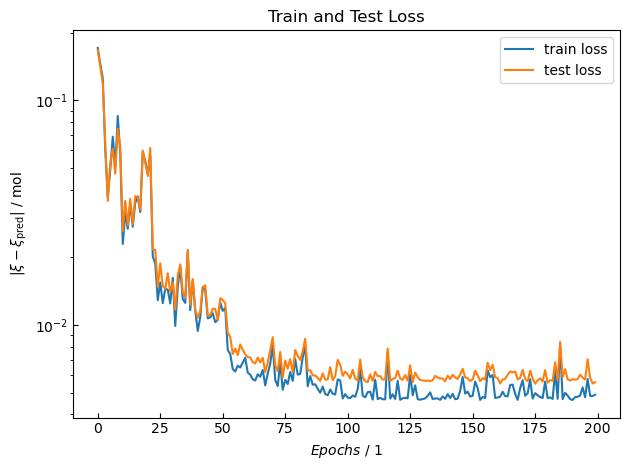

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

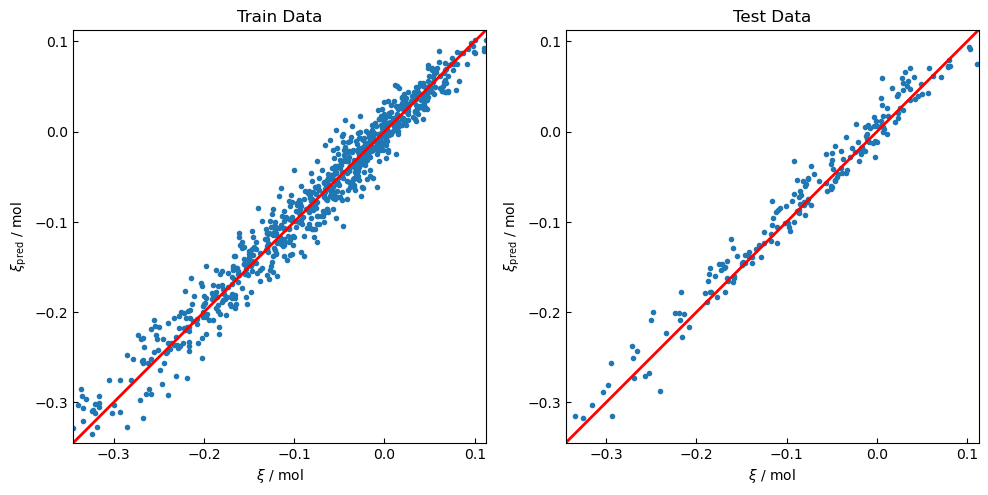

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

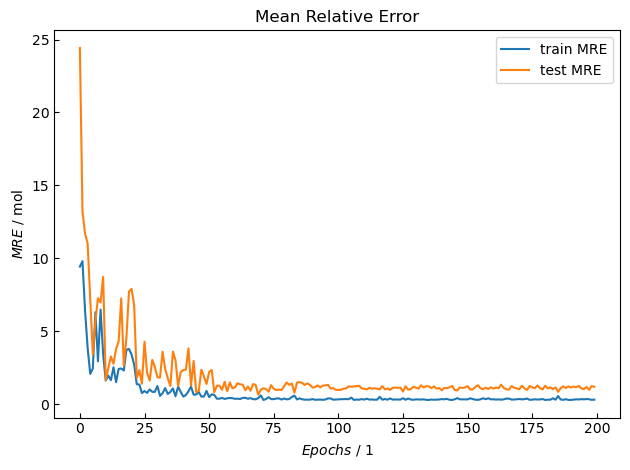

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

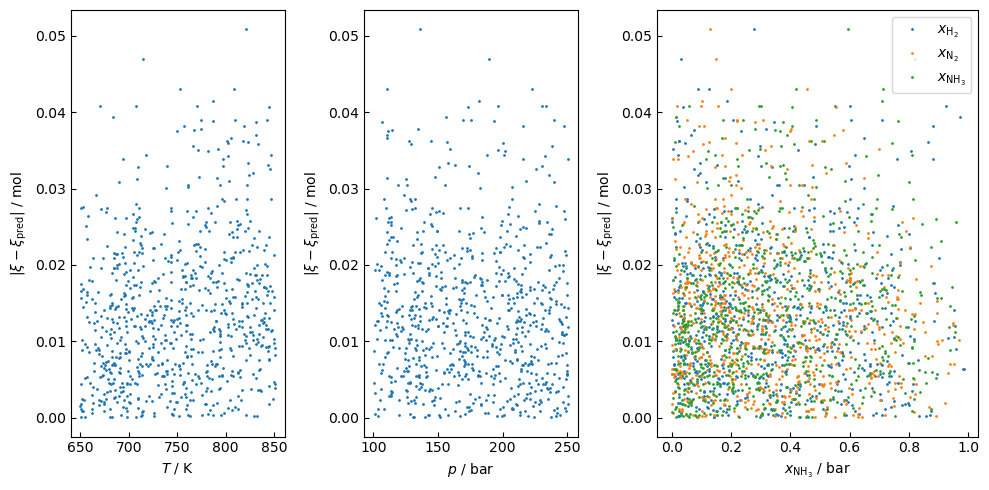

In [12]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

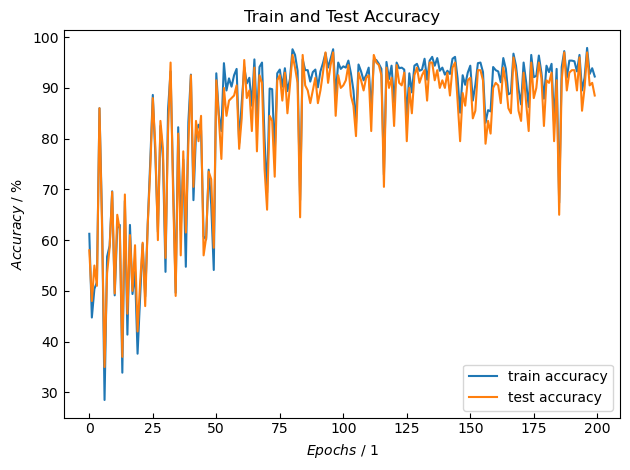

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [14]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[8.3747e+02, 1.8942e+02, 1.3452e-03, 3.2090e-01, 6.7776e-01],
        [8.2122e+02, 1.3565e+02, 2.7706e-01, 1.2761e-01, 5.9533e-01],
        [7.8002e+02, 1.6525e+02, 7.6345e-02, 4.6048e-02, 8.7761e-01],
        [8.1745e+02, 1.4461e+02, 2.3334e-02, 4.6445e-01, 5.1221e-01],
        [6.8318e+02, 1.0064e+02, 2.2638e-01, 5.3887e-02, 7.1973e-01],
        [7.7550e+02, 1.6932e+02, 1.9191e-01, 7.5363e-01, 5.4461e-02],
        [7.1806e+02, 1.6642e+02, 3.5465e-01, 5.7999e-01, 6.5358e-02],
        [7.2149e+02, 1.1730e+02, 2.6886e-01, 1.2726e-01, 6.0387e-01],
        [8.4185e+02, 2.1662e+02, 1.2478e-01, 1.7556e-01, 6.9965e-01],
        [6.9987e+02, 1.6659e+02, 5.2364e-01, 8.3560e-02, 3.9280e-01],
        [7.6657e+02, 1.8731e+02, 3.2162e-01, 1.4388e-01, 5.3449e-01],
        [8.0787e+02, 1.1347e+02, 5.4088e-01, 9.2709e-02, 3.6641e-01],
        [6.6425e+02, 2.1912e+02, 3.8559e-01, 3.7120e-01, 2.4321e-01],
        [8.3569e+02, 1.4553e+02, 5.5183e-01, 3.5300e-01, 9.5170e-02],
        [7.3840e+02,

#### Einblick in Netzwerk

In [15]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.9503, 0.8926, 0.9418, 0.9367, 0.9423], requires_grad=True),
 Parameter containing:
 tensor([-0.0986,  0.0168, -0.1183,  0.1452,  0.0045], requires_grad=True),
 Parameter containing:
 tensor([[ 0.2260,  0.1161,  0.1542, -0.1880,  0.2615],
         [-0.2410,  0.0559,  0.1075, -0.0190, -0.0606],
         [ 0.2475,  0.3438,  0.1136,  0.4636,  0.0456],
         [-0.0058, -0.2210,  0.2935, -0.4498,  0.2715],
         [-0.1969,  0.0268, -0.0432, -0.0438, -0.0458],
         [ 0.0885,  0.0252,  0.0208, -0.3226,  0.3342],
         [ 0.1240,  0.3205, -0.5003, -0.0330, -0.3894],
         [-0.1959,  0.2375,  0.0976, -0.0611, -0.2967],
         [ 0.2741, -0.1723,  0.0089,  0.4088, -0.0843],
         [ 0.2457,  0.3050,  0.2208, -0.1615, -0.3686],
         [ 0.0557, -0.0649, -0.0977, -0.2321, -0.0192],
         [ 0.1988,  0.3761, -0.3114,  0.1612, -0.4305],
         [ 0.3693,  0.1152, -0.2279,  0.2578,  0.1010],
         [ 0.1569,  0.3465,  0.0710,  0.3365,  0.2146],


In [16]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.8626, 0.6724, 0.2073, 0.1754, 0.2450],
        [0.3338, 0.6916, 0.5476, 0.3274, 0.6893]])
tensor([[-0.1347],
        [-0.0056]], grad_fn=<AddmmBackward0>)


In [17]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [18]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[8.3342e+02, 1.2895e+02, 4.8415e-01, 1.0500e-01, 4.1085e-01],
        [8.3073e+02, 1.0875e+02, 4.2303e-01, 8.0101e-02, 4.9687e-01],
        [7.4359e+02, 1.2095e+02, 9.8929e-02, 3.9438e-01, 5.0669e-01],
        [8.2703e+02, 1.7054e+02, 6.7632e-01, 1.7162e-01, 1.5206e-01],
        [8.0712e+02, 1.1333e+02, 4.6350e-01, 3.3071e-01, 2.0579e-01],
        [6.9348e+02, 1.2853e+02, 1.7128e-01, 5.3373e-01, 2.9499e-01],
        [7.4403e+02, 1.4598e+02, 2.5051e-01, 6.5827e-01, 9.1223e-02],
        [6.8684e+02, 2.3671e+02, 5.1572e-01, 2.7098e-01, 2.1330e-01],
        [7.2714e+02, 2.3295e+02, 2.9838e-01, 5.9863e-01, 1.0298e-01],
        [7.1468e+02, 1.7358e+02, 1.5285e-01, 3.4958e-02, 8.1220e-01],
        [7.0393e+02, 1.4382e+02, 6.7222e-01, 8.9779e-02, 2.3800e-01],
        [7.5918e+02, 1.8176e+02, 3.3022e-01, 1.2455e-01, 5.4523e-01],
        [7.0887e+02, 2.4880e+02, 4.3664e-01, 1.7767e-01, 3.8570e-01],
        [7.4053e+02, 1.9513e+02, 4.4589e-01, 1.0410e-01, 4.5001e-01],
        [6.7621e+02,